# Notebook 2:<br> **Model Training, Tuning, and Evaluation**

This notebook trains and optimizes classification models for the OULAD early-warning task using the preprocessed artifacts from `01_dataset_preprocessing.ipynb`.

**Prediction time:** <br>
Day `CUTOFF_DAY` (as defined in Notebook 1)  

**Target:** <br>
The classes are mapped to the `risk_tier`:
1. Low Risk: Pass/Distinction  
2. Medium Risk: Fail  
3. High Risk: Withdrawn  

## Setup Notebook

In [2]:
# Imports

# Standard library imports
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedGroupKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Project utilities
import sys
sys.path.append(str(Path.cwd().parent))
from utils import summarize_cv, SCORING_METRICS

# Constants (match Notebook 1)
RANDOM_STATE = 42
CUTOFF_DAY = 98     # Important: Ensure that this is the same as in Notebook 1

# Directories for outputs
# With a method to resolve outputs relative to current working directory first (robust when kernel cwd varies)
candidate_out = Path.cwd() / "outputs"
if candidate_out.exists():
    OUT_DIR = candidate_out
else:
    OUT_DIR = Path("../outputs")
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
DATA_DIR = OUT_DIR / "data"
MODEL_DIR = OUT_DIR / "models"

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

## Data Loading and Setup

### 1. Train/Test Data

Load the outputs from the preprocessing:

In [3]:
def load_series_csv(path: Path) -> pd.Series:
    df = pd.read_csv(path)
    if df.shape[1] == 1:
        return df.iloc[:, 0]
    return df.iloc[:, -1]

# Paths:
X_train_path = DATA_DIR / "processed" / "X_train_raw.csv"
X_test_path  = DATA_DIR / "processed" / "X_test_raw.csv"
y_train_path = DATA_DIR / "processed" / "y_train.csv"
y_test_path  = DATA_DIR / "processed" / "y_test.csv"
groups_path  = DATA_DIR / "processed" / "groups_train.csv"
preprocess_path = MODEL_DIR / "preprocess_pipeline.joblib"

# Load processed data:
X_train = pd.read_csv(X_train_path)
X_test  = pd.read_csv(X_test_path)
y_train = load_series_csv(y_train_path)
y_test  = load_series_csv(y_test_path)
groups_train = load_series_csv(groups_path)

preprocess = joblib.load(preprocess_path)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("groups_train:", groups_train.shape)

X_train: (20284, 37)
X_test: (5069, 37)
y_train: (20284,)
y_test: (5069,)
groups_train: (20284,)


### 2. Sanity Checks

In [4]:
# Show the % distribution of classes in the TRAIN split
print("Train class distribution (%):")
print((y_train.value_counts(normalize=True) * 100).round(1))  # normalize=True -> proportions; *100 -> percent

# Show the % distribution of classes in the TEST split
print("\nTest class distribution (%):")
print((y_test.value_counts(normalize=True) * 100).round(1))

# Ensure training matrices/vectors align:
# - X_train rows must match y_train labels
# - groups_train must have one group ID per training row (for group-aware CV)
assert len(X_train) == len(y_train) == len(groups_train), "Train X/y/groups lengths do not match."

# Ensure test features and labels align (one label per test row)
assert len(X_test) == len(y_test), "Test X/y lengths do not match."


Train class distribution (%):
risk_tier
Low Risk       60.7
Medium Risk    27.8
High Risk      11.5
Name: proportion, dtype: float64

Test class distribution (%):
risk_tier
Low Risk       60.7
Medium Risk    27.8
High Risk      11.5
Name: proportion, dtype: float64


### 3. Cross-Validation Setup

Cross-validation (CV) provides a more reliable estimate of model performance than a single split. The solution is using **StratifiedGroupKFold** with **Macro-F1** as a primary indicator (better for imbalanced classes). 


In [5]:
# Define a 5-fold stratified, group-aware CV splitter
cv = StratifiedGroupKFold(
    n_splits=5,                     # number of folds
    shuffle=True,                   # shuffle before splitting for randomness
    random_state=RANDOM_STATE       # reproducible fold assignments
)

## Models

### 4. Models Used

1. **Logistic Regression (Multimodal)** since it models all classes jointly in a single probability framework.

2. **Random Forest** since it uses an ensemble of decision trees that reduces overfitting by training many diverse trees and averaging their predictions, while still offering practical interpretability through feature-importance scores.


#### 4.1. Logistic Regression (Multimodal)

In [6]:
# Define Logistic Regression pipeline
logreg_pipe = Pipeline(steps=[              # Parameters:
    ("preprocess", preprocess),             # Preprocessing step
    ("model", LogisticRegression(           # Logistic Regression classifier
        max_iter=3000,                      # Increased iterations for convergence
        solver="saga",                      # Solver suitable for large datasets and supports L1 regularization
        random_state=RANDOM_STATE           # For reproducibility
    ))
])

#### 4.2. Random Forest

In [7]:
# Define Random Forest pipeline
rf_pipe = Pipeline(steps=[                  # Parameters:
    ("preprocess", preprocess),             # Preprocessing step
    ("model", RandomForestClassifier(       # Random Forest classifier
        n_estimators=500,                   # Number of trees in the forest
        random_state=RANDOM_STATE,          # For reproducibility   
        n_jobs=-1,                          # Use all available cores
        class_weight="balanced_subsample"   # Handle class imbalance      
    ))
])


#### 4.3. Define Models Based on Pipelines

In [8]:
# Define models dictionary
models = {
    "logreg_default": logreg_pipe,  # Use default Logistic Regression pipeline
    "rf_default": rf_pipe,          # Use default Random Forest pipeline
}


### 4.4. Compare Initial Models

Compare the initial models (no tuning yet).

In [9]:
# Cross-validate each model on training data only, summarize results
rows = []
for name, pipe in models.items():           # Parallel loop over models
    res = cross_validate(                   # Arguments:
        pipe,                               # Model pipeline
        X_train,                            # Training features
        y_train,                            # Training labels
        groups=groups_train,                # Group labels for the samples used while splitting the dataset into train/test set
        cv=cv,                              # Cross-validation splitting strategy
        scoring=SCORING_METRICS,            # Scoring metrics
        return_train_score=False            # Do not return training scores
    )
    rows.append(summarize_cv(name, res))    # Summarize CV results and store

# Create comparison DataFrame and save to CSV
compare_df = pd.DataFrame(rows).sort_values("macro_f1_mean", ascending=False)
# Save to CSV
compare_df.to_csv(TAB_DIR / "table_12_model_comparison_cv_train_only.csv", index=False)
# Display comparison DataFrame
compare_df

,model,macro_f1_mean,macro_f1_std,balanced_acc_mean,balanced_acc_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std,fit_time_mean
1,rf_default,0.498384,0.002729,0.512165,0.003140,0.611766,0.021072,0.512165,0.003140,6.374318
0,logreg_default,0.455669,0.003851,0.474944,0.003341,0.562743,0.059405,0.474944,0.003341,16.184994


## Hyperparameter Tuning

### 5. Logistic Regression Tunning

Focus on a small set of high-impact (high-sensitivity) parameters and keep the search space manageable:

- **Regularization strength (`C`)**:<br> Controls how strongly the model is regularized.
- **Penalty (`l1` vs `l2`)**:<br> Changes the type of regularization. 
- **Class weights (`class_weight=None` vs `'balanced'`)**: <br>Addresses class imbalance by increasing the penalty for misclassifying minority classes.

We select the best configuration using macro-F1 (primary metric for imbalanced multiclass problems) and also track balanced accuracy, macro-precision, and macro-recall to understand trade-offs across the three risk tiers.

Rumtime Notes:

For `"model__C": [0.01, 0.1, 1.0, 10.0],` the runtime was:
1. With a 2-Cores, 8GB RAM, the run took about 55 minutes.
2. With a 4-Cores, 16GB RAM, the run took about the same time... 

For `"model__C": [0.1, 1.0],` (half of the fits):
1. With a 4-Cores, 16GB RAM, the run took about 22 minutes.

In [10]:
# Tune: regularization strength (C), type (l1_ratio), and class weights (imbalance)
logreg_grid = {
    "model__C": [0.1, 1.0],             # This can be changed for faster runs (Configurations: SLOW [0.01, 0.1, 1.0, 10.0] and FASTER [0.1, 1.0])
    "model__l1_ratio": [0.0, 1.0],                  # L2 (0.0) vs L1 (1.0) regularization
    "model__class_weight": [None, "balanced"],      # Class weight options to handle imbalance
}

logreg_search = GridSearchCV(   # Parameters:
    estimator=logreg_pipe,      # the pipeline
    param_grid=logreg_grid,     # the hyperparameter grid
    scoring=SCORING_METRICS,    # the scoring metrics    
    refit="macro_f1",           # refit best model by macro-F1  
    cv=cv,                      # the CV splitter
    n_jobs=1,                   # use all cores and memory safeguard
    verbose=2,                  # print progress
    error_score="raise"         # fails fast if a param combo is invalid
)

print(f"Starting Logistic Regression GridSearchCV: "
      f"{len(logreg_search.param_grid['model__C']) * len(logreg_search.param_grid['model__l1_ratio']) * len(logreg_search.param_grid['model__class_weight'])} "
      f"param combinations × {cv.get_n_splits()} folds")

# Fit Logistic Regression with Grid Search on training data
# Note: This may take some time depending on the grid size and data (see runtime notes above)
logreg_search.fit(X_train, y_train, groups=groups_train)

# Save full CV results for reporting
logreg_results = (
    pd.DataFrame(logreg_search.cv_results_)
      .sort_values("mean_test_macro_f1", ascending=False)
)
logreg_results.to_csv(TAB_DIR / "table_13_logreg_gridsearch_cv_results.csv", index=False)

print("\n Run of all fits finished!")
print("Best LogReg params:", logreg_search.best_params_)
print("Best LogReg macro-F1:", logreg_search.best_score_)

logreg_results.head(10)

Starting Logistic Regression GridSearchCV: 8 param combinations × 5 folds
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.0; total time=  21.2s
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.0; total time=  17.0s
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.0; total time=  18.1s
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.0; total time=  12.9s
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=0.0; total time=  11.7s
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=1.0; total time=  17.6s
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=1.0; total time=  11.8s
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=1.0; total time=  16.0s
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=1.0; total time=  18.2s
[CV] END model__C=0.1, model__class_weight=None, model__l1_ratio=

/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.0; total time=  44.1s


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.0; total time=  45.1s


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.0; total time=  45.4s
[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.0; total time=   9.4s
[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=0.0; total time=  11.7s


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=1.0; total time= 1.0min


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=1.0; total time=  59.3s


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=1.0; total time= 1.1min
[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=1.0; total time=  16.0s
[CV] END model__C=0.1, model__class_weight=balanced, model__l1_ratio=1.0; total time=  15.3s
[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=0.0; total time=  15.1s
[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=0.0; total time=  13.0s
[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=0.0; total time=  14.3s
[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=0.0; total time=  18.3s
[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=0.0; total time=  15.9s


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=1.0; total time= 1.0min


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=1.0; total time= 1.0min


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=1.0; total time=  59.4s
[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=1.0; total time=  38.0s
[CV] END model__C=1.0, model__class_weight=None, model__l1_ratio=1.0; total time=  34.0s


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=0.0; total time=  47.2s


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=0.0; total time=  47.5s


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=0.0; total time=  44.3s
[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=0.0; total time=  12.5s
[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=0.0; total time=  14.1s


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=1.0; total time= 1.0min


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=1.0; total time= 1.0min


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=1.0; total time= 1.0min
[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=1.0; total time=  23.4s
[CV] END model__C=1.0, model__class_weight=balanced, model__l1_ratio=1.0; total time=  21.6s

Done.
Best LogReg params: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__l1_ratio': 1.0}
Best LogReg macro-F1: 0.5154160382539257


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_model__l1_ratio,params,split0_test_macro_f1,split1_test_macro_f1,split2_test_macro_f1,split3_test_macro_f1,split4_test_macro_f1,mean_test_macro_f1,std_test_macro_f1,rank_test_macro_f1,split0_test_balanced_acc,split1_test_balanced_acc,split2_test_balanced_acc,split3_test_balanced_acc,split4_test_balanced_acc,mean_test_balanced_acc,std_test_balanced_acc,rank_test_balanced_acc,split0_test_precision_macro,split1_test_precision_macro,split2_test_precision_macro,split3_test_precision_macro,split4_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_test_recall_macro,split1_test_recall_macro,split2_test_recall_macro,split3_test_recall_macro,split4_test_recall_macro,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro
3,43.179268,22.598409,0.066138,0.009080,0.1,balanced,1.0,"{'model__C': 0.1, 'model__class_weight': 'bala...",0.520000,0.511461,0.520451,0.519403,0.505764,0.515416,0.005849,1,0.533064,0.524602,0.533431,0.532074,0.515001,0.527634,0.007093,3,0.520413,0.512957,0.522296,0.521567,0.507748,0.516996,0.005701,7,0.533064,0.524602,0.533431,0.532074,0.515001,0.527634,0.007093,3
2,31.069699,16.799129,0.068494,0.007678,0.1,balanced,0.0,"{'model__C': 0.1, 'model__class_weight': 'bala...",0.522390,0.512326,0.518083,0.518881,0.504743,0.515285,0.006183,2,0.536515,0.527100,0.531373,0.532214,0.514310,0.528302,0.007608,1,0.523127,0.514315,0.520879,0.521692,0.506926,0.517388,0.006042,5,0.536515,0.527100,0.531373,0.532214,0.514310,0.528302,0.007608,1
7,45.157761,18.565866,0.062745,0.009320,1.0,balanced,1.0,"{'model__C': 1.0, 'model__class_weight': 'bala...",0.520319,0.512280,0.518315,0.518532,0.505322,0.514954,0.005528,3,0.533691,0.527245,0.531693,0.531356,0.514876,0.527772,0.006780,2,0.521379,0.514139,0.521221,0.521507,0.507180,0.517085,0.005690,6,0.533691,0.527245,0.531693,0.531356,0.514876,0.527772,0.006780,2
6,33.061407,16.232460,0.068890,0.011614,1.0,balanced,0.0,"{'model__C': 1.0, 'model__class_weight': 'bala...",0.519676,0.512253,0.517051,0.518717,0.504741,0.514488,0.005502,4,0.533220,0.527551,0.530536,0.531492,0.514285,0.527417,0.006819,4,0.521134,0.514124,0.519980,0.521681,0.506774,0.516739,0.005664,8,0.533220,0.527551,0.530536,0.531492,0.514285,0.527417,0.006819,4
4,15.237631,1.808847,0.067827,0.018723,1.0,None,0.0,"{'model__C': 1.0, 'model__class_weight': None,...",0.460118,0.459670,0.449917,0.455217,0.453420,0.455669,0.003851,5,0.478284,0.478156,0.469850,0.476127,0.472301,0.474944,0.003341,5,0.678279,0.549203,0.522986,0.548877,0.514370,0.562743,0.059405,4,0.478284,0.478156,0.469850,0.476127,0.472301,0.474944,0.003341,5
0,16.127770,3.459068,0.065673,0.008850,0.1,None,0.0,"{'model__C': 0.1, 'model__class_weight': None,...",0.460981,0.460021,0.449297,0.455039,0.452276,0.455523,0.004462,6,0.478244,0.478452,0.469123,0.475831,0.471070,0.474544,0.003797,7,0.690196,0.557614,0.522642,0.571250,0.520165,0.572373,0.062129,2,0.478244,0.478452,0.469123,0.475831,0.471070,0.474544,0.003797,7
5,50.302650,11.789154,0.070635,0.003808,1.0,None,1.0,"{'model__C': 1.0, 'model__class_weight': None,...",0.459437,0.459912,0.449649,0.454975,0.452691,0.455333,0.003930,7,0.477557,0.478452,0.469714,0.475831,0.471550,0.474621,0.003414,6,0.677728,0.557279,0.542698,0.548767,0.520263,0.569347,0.055561,3,0.477557,0.478452,0.469714,0.475831,0.471550,0.474621,0.003414,6
1,18.313223,5.415893,0.054457,0.000447,0.1,None,1.0,"{'model__C': 0.1, 'model__class_weight': None,...",0.458626,0.458249,0.449336,0.454847,0.449064,0.454024,0.004154,8,0.476620,0.477343,0.468999,0.476016,0.469436,0.473683,0.003673,8,0.717143,0.586768,0.543764,0.606983,0.478049,0.586541,0.078836,1,0.476620,0.477343,0.468999,0.476016,0.469436,0.473683,0.003673,8


### 6. Random Forest Tunning

Focus on a small set of high-impact (high-sensitivity) parameters and keep the search space manageable:

- **Regularization strength (`C`)**:<br> Controls how strongly the model is regularized.
- **Penalty (`l1` vs `l2`)**:<br> Changes the type of regularization. 
- **Class weights (`class_weight=None` vs `'balanced'`)**: <br>Addresses class imbalance by increasing the penalty for misclassifying minority classes.

We select the best configuration using macro-F1 (primary metric for imbalanced multiclass problems) and also track balanced accuracy, macro-precision, and macro-recall to understand trade-offs across the three risk tiers.

For `n_iter=10,`:
1. With a 4-Cores, 16GB RAM, the run took about 15 minutes.

In [11]:
# Tune Random Forest hyperparameters with Randomized Search
rf_param_dist = {
    "model__n_estimators": [300, 500, 800],                     # number of trees in the forest
    "model__max_depth": [None, 10, 20, 30],                     # maximum depth of the tree
    "model__min_samples_split": [2, 5, 10],                     # minimum samples required to split an internal node
    "model__min_samples_leaf": [1, 2, 5],                       # minimum samples required at each leaf node
    "model__max_features": ["sqrt", 0.5, 0.8],                  # number of features to consider at each split
    "model__class_weight": ["balanced_subsample", "balanced"],  # handle class imbalance
}

rf_search = RandomizedSearchCV(             # Parameters:
    estimator=rf_pipe,                      # the pipeline
    param_distributions=rf_param_dist,      # the hyperparameter distributions
    n_iter=10,                               # number of random param combinations to try (affects runtime)
    scoring=SCORING_METRICS,                # the scoring metrics
    refit="macro_f1",                       # refit best model by macro-F1
    cv=cv,                                  # the CV splitter
    n_jobs=-1,                              # use all cores and memory safeguard
    random_state=RANDOM_STATE,              # reproducibility
    verbose=2                               # print progress
)

# 
rf_search.fit(X_train, y_train, groups=groups_train)

# 
rf_results = pd.DataFrame(rf_search.cv_results_).sort_values("mean_test_macro_f1", ascending=False)
rf_results.to_csv(TAB_DIR / "table_14_rf_randomsearch_cv_results.csv", index=False)

print("\n Run of all fits finished!")
print("Best RF params:", rf_search.best_params_)
print("Best RF macro-F1:", rf_search.best_score_)
rf_results.head(10)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__class_weight=balanced, model__max_depth=30, model__max_features=0.8, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=800; total time= 3.0min
[CV] END model__class_weight=balanced, model__max_depth=30, model__max_features=0.8, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=800; total time= 3.0min
[CV] END model__class_weight=balanced, model__max_depth=30, model__max_features=0.8, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=800; total time= 3.0min
[CV] END model__class_weight=balanced, model__max_depth=30, model__max_features=0.8, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=800; total time= 3.0min
[CV] END model__class_weight=balanced_subsample, model__max_depth=20, model__max_features=0.8, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=500; total time= 1.9min
[CV] END 

/usr/local/python/3.12.1/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__class_weight=balanced, model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=800; total time=  31.9s
[CV] END model__class_weight=balanced, model__max_depth=30, model__max_features=0.8, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=800; total time= 2.9min
[CV] END model__class_weight=balanced, model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=800; total time=  30.4s
[CV] END model__class_weight=balanced, model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=800; total time=  32.3s
[CV] END model__class_weight=balanced, model__max_depth=30, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=800; total time=  30.9s
[CV] END model__class_weight=balanced_subsample, model__max_depth=20, mo

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,param_model__class_weight,params,split0_test_macro_f1,split1_test_macro_f1,split2_test_macro_f1,split3_test_macro_f1,split4_test_macro_f1,mean_test_macro_f1,std_test_macro_f1,rank_test_macro_f1,split0_test_balanced_acc,split1_test_balanced_acc,split2_test_balanced_acc,split3_test_balanced_acc,split4_test_balanced_acc,mean_test_balanced_acc,std_test_balanced_acc,rank_test_balanced_acc,split0_test_precision_macro,split1_test_precision_macro,split2_test_precision_macro,split3_test_precision_macro,split4_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_test_recall_macro,split1_test_recall_macro,split2_test_recall_macro,split3_test_recall_macro,split4_test_recall_macro,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro
7,75.763047,1.298861,0.906206,0.033995,800,5,5,0.5,10,balanced_subsample,"{'model__n_estimators': 800, 'model__min_sampl...",0.558133,0.566191,0.571627,0.570628,0.542148,0.561745,0.010894,1,0.561199,0.572984,0.578434,0.576842,0.545150,0.566922,0.012445,1,0.559030,0.568213,0.570728,0.574111,0.545468,0.563510,0.010317,8,0.561199,0.572984,0.578434,0.576842,0.545150,0.566922,0.012445,1
5,44.806165,2.113874,0.640957,0.085162,500,10,2,0.5,10,balanced,"{'model__n_estimators': 500, 'model__min_sampl...",0.552859,0.561956,0.571608,0.568666,0.545901,0.560198,0.009625,2,0.555603,0.567430,0.577016,0.573371,0.548415,0.564367,0.010787,2,0.553885,0.564180,0.570382,0.571537,0.548854,0.561768,0.008993,9,0.555603,0.567430,0.577016,0.573371,0.548415,0.564367,0.010787,2
3,8.569751,0.247932,0.540559,0.100597,300,10,5,sqrt,10,balanced,"{'model__n_estimators': 300, 'model__min_sampl...",0.557476,0.553696,0.568639,0.567191,0.540477,0.557496,0.010220,3,0.561961,0.560466,0.576269,0.573078,0.543030,0.562961,0.011696,3,0.555658,0.551958,0.565550,0.567024,0.540324,0.556103,0.009745,10,0.561961,0.560466,0.576269,0.573078,0.543030,0.562961,0.011696,3
4,60.736436,1.677701,0.568799,0.122371,300,2,5,0.8,None,balanced_subsample,"{'model__n_estimators': 300, 'model__min_sampl...",0.538224,0.564612,0.565319,0.556151,0.535214,0.551904,0.012846,4,0.535610,0.560541,0.559880,0.552423,0.532730,0.548237,0.011869,5,0.560240,0.585973,0.594912,0.579911,0.549239,0.574055,0.016841,4,0.535610,0.560541,0.559880,0.552423,0.532730,0.548237,0.011869,5
6,19.800710,1.054030,0.802008,0.109365,500,2,5,sqrt,20,balanced_subsample,"{'model__n_estimators': 500, 'model__min_sampl...",0.534936,0.556873,0.571298,0.552189,0.536076,0.550274,0.013609,5,0.536651,0.555177,0.565826,0.550924,0.533732,0.548462,0.011909,4,0.556237,0.575439,0.606980,0.571028,0.555959,0.573129,0.018632,5,0.536651,0.555177,0.565826,0.550924,0.533732,0.548462,0.011909,4
8,64.054533,0.301753,0.594900,0.095406,300,10,2,0.8,20,balanced_subsample,"{'model__n_estimators': 300, 'model__min_sampl...",0.535466,0.555423,0.568779,0.549533,0.531318,0.548104,0.013598,6,0.532658,0.551947,0.562448,0.546760,0.529544,0.544671,0.012218,7,0.556229,0.577429,0.595982,0.572348,0.547838,0.569965,0.016832,7,0.532658,0.551947,0.562448,0.546760,0.529544,0.544671,0.012218,7
2,29.526803,1.794651,1.037894,0.118625,800,10,5,sqrt,30,balanced,"{'model__n_estimators': 800, 'model__min_sampl...",0.531828,0.547994,0.559551,0.551708,0.537482,0.545713,0.009931,7,0.534469,0.549154,0.557901,0.550860,0.535173,0.545511,0.009211,6,0.558482,0.570192,0.595553,0.574260,0.560478,0.571793,0.013254,6,0.534469,0.549154,0.557901,0.550860,0.535173,0.545511,0.009211,6
1,110.826460,3.175502,0.769020,0.114869,500,5,1,0.8,20,balanced_subsample,"{'model__n_estimators': 500, 'model__min_sampl...",0.524018,0.556682,0.551291,0.540208,0.528135,0.540067,0.012665,8,0.524708,0.551498,0.546222,0.539040,0.525298,0.537353,0.010833,9,0.557576,0.591796,0.595862,0.573178,0.552547,0.574192,0.017465,3,0.524708,0.55

## Model Comparison

### 7. Compare Models

The modesl to compare are:
1. Baseline (which predicted the majority class only)
2. Initial models (from step 4.4. Compare Initial Models)
3. Tuned best models (from steps 5. Logistic Regression Tunning and 6. Random Forest Tuning)

In [14]:
# Load baseline (from Table 11)
baseline_path = TAB_DIR / "table_11_baseline_dummy_cv_train_only.csv"
baseline_df = pd.read_csv(baseline_path)
baseline_row = {
    "model": "dummy_most_frequent",
    "macro_f1_mean": float(baseline_df["macro_f1_mean"].iloc[0]),
    "macro_f1_std": float(baseline_df["macro_f1_std"].iloc[0]),
    "balanced_acc_mean": float(baseline_df["balanced_acc_mean"].iloc[0]),
    "balanced_acc_std": float(baseline_df["balanced_acc_std"].iloc[0]),
}

# Extract raw cv results DataFrames so we can pull the std for the best config
logreg_cv = pd.DataFrame(logreg_search.cv_results_)
rf_cv = pd.DataFrame(rf_search.cv_results_)

# Create summary DataFrame comparing baseline, default, and tuned models
tuned_summary = pd.DataFrame([
    baseline_row,
    compare_df[compare_df["model"] == "logreg_default"].iloc[0].to_dict(),
    compare_df[compare_df["model"] == "rf_default"].iloc[0].to_dict(),
    {
        "model": "logreg_tuned_best",
        "macro_f1_mean": float(logreg_search.best_score_),
        "macro_f1_std": float(logreg_cv.loc[logreg_search.best_index_, "std_test_macro_f1"]),
        "balanced_acc_mean": float(logreg_results.loc[logreg_results.index[0], "mean_test_balanced_acc"]),
        "balanced_acc_std": float(logreg_results.loc[logreg_results.index[0], "std_test_balanced_acc"]),
        "precision_macro_mean": float(logreg_results.loc[logreg_results.index[0], "mean_test_precision_macro"]),
        "precision_macro_std": float(logreg_results.loc[logreg_results.index[0], "std_test_precision_macro"]),
        "recall_macro_mean": float(logreg_results.loc[logreg_results.index[0], "mean_test_recall_macro"]),
        "recall_macro_std": float(logreg_results.loc[logreg_results.index[0], "std_test_recall_macro"]),
        "fit_time_mean": np.nan,
    },
    {
        "model": "rf_tuned_best",
        "macro_f1_mean": float(rf_search.best_score_),
        "macro_f1_std": float(rf_cv.loc[rf_search.best_index_, "std_test_macro_f1"]),
        "balanced_acc_mean": float(rf_results.loc[rf_results.index[0], "mean_test_balanced_acc"]),
        "balanced_acc_std": float(rf_results.loc[rf_results.index[0], "std_test_balanced_acc"]),
        "precision_macro_mean": float(rf_results.loc[rf_results.index[0], "mean_test_precision_macro"]),
        "precision_macro_std": float(rf_results.loc[rf_results.index[0], "std_test_precision_macro"]),
        "recall_macro_mean": float(rf_results.loc[rf_results.index[0], "mean_test_recall_macro"]),
        "recall_macro_std": float(rf_results.loc[rf_results.index[0], "std_test_recall_macro"]),
        "fit_time_mean": np.nan,
    },
])

tuned_summary = tuned_summary.sort_values("macro_f1_mean", ascending=False)
tuned_summary.to_csv(TAB_DIR / "table_15_baseline_vs_models_train_cv_summary.csv", index=False)
tuned_summary


,model,macro_f1_mean,macro_f1_std,balanced_acc_mean,balanced_acc_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std,fit_time_mean
4,rf_tuned_best,0.561745,0.010894,0.566922,0.012445,0.563510,0.010317,0.566922,0.012445,NaN
3,logreg_tuned_best,0.515416,0.005849,0.527634,0.007093,0.516996,0.005701,0.527634,0.007093,NaN
2,rf_default,0.498384,0.002729,0.512165,0.003140,0.611766,0.021072,0.512165,0.003140,6.374318
1,logreg_default,0.455669,0.003851,0.474944,0.003341,0.562743,0.059405,0.474944,0.003341,16.184994
0,dummy_most_frequent,0.251772,0.000028,0.333333,0.000000,NaN,NaN,NaN,NaN,NaN


### 8. Select Best Model

Based on the table, the best model is `rf_tuned_best` (Random Forest Tuned). It has the highest macro-F1 mean (0.561745) and the highest balanced accuracy mean (0.566922), which are your key “imbalance-aware” metrics for the 3 risk tiers.

In [40]:
# Pick best tuned pipeline
best_name = "logreg_tuned_best" if logreg_search.best_score_ >= rf_search.best_score_ else "rf_tuned_best"
best_pipe = logreg_search.best_estimator_ if best_name == "logreg_tuned_best" else rf_search.best_estimator_

print("Selected best model: [ ", best_name, " ]")

# Fit on full training set
best_pipe.fit(X_train, y_train)

# Predict on test set (single final evaluation)
y_pred = best_pipe.predict(X_test)

# Core test metrics
test_metrics = {
    "model": best_name,
    "macro_f1": f1_score(y_test, y_pred, average="macro"),
    "balanced_acc": balanced_accuracy_score(y_test, y_pred),
    "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
}
test_metrics_df = pd.DataFrame([test_metrics])
test_metrics_df.to_csv(TAB_DIR / "table_16_test_metrics_summary.csv", index=False)

# Classification report (per class)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T.reset_index().rename(columns={"index": "label"})
report_df.to_csv(TAB_DIR / "table_17_test_classification_report.csv", index=False)

# Save predictions for audit/error analysis
pred_df = pd.DataFrame({"y_true": y_test.values, "y_pred": y_pred})
pred_df.to_csv(DATA_DIR / "test_predictions.csv", index=False)

# Save model artifact + metadata
joblib.dump(best_pipe, MODEL_DIR / "best_model.joblib")
with open(MODEL_DIR / "best_model_meta.json", "w") as f:
    json.dump(
        {
            "best_name": best_name,
            "CUTOFF_DAY": CUTOFF_DAY,
            "train_cv_best_macro_f1": float(max(logreg_search.best_score_, rf_search.best_score_)),
        },
        f,
        indent=2
    )

print(test_metrics_df)
report_df.head(10)


Selected best model: [  rf_tuned_best  ]
           model  macro_f1  balanced_acc  precision_macro  recall_macro
0  rf_tuned_best  0.565129      0.569185          0.57009      0.569185


,label,precision,recall,f1-score,support
0,High Risk,0.248792,0.352740,0.291785,584.000000
1,Low Risk,0.830121,0.826073,0.828092,3076.000000
2,Medium Risk,0.631356,0.528744,0.575512,1409.000000
3,accuracy,0.688893,0.688893,0.688893,0.688893
4,macro avg,0.570090,0.569185,0.565129,5069.000000
5,weighted avg,0.707896,0.688893,0.696096,5069.000000


**Interpretation:**
Based on precision and F1 score, the model performs well for "Low Risk" predictions, poorly on "Medium Risk", and very bad on "High Risk" (which is what matters most). Additional investigation is required to better understand the outcomes.

## Evaluating Results

### 9. Confusion Matrix

The confusion matrix shows which risk tiers are being confused, especially whether "High Risk" is being misclassified as "Medium and Low Risks".

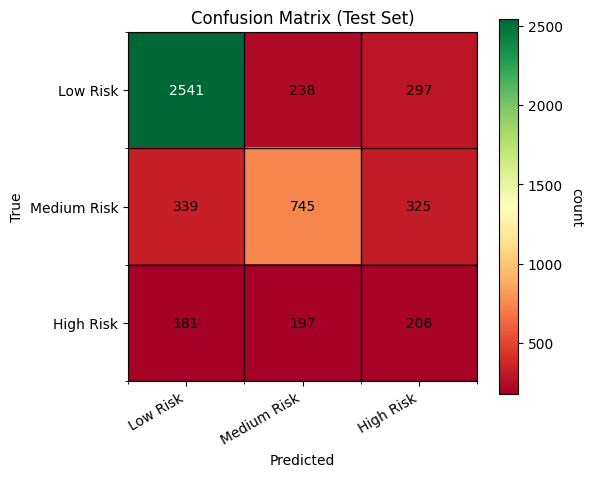

,pred_Low Risk,pred_Medium Risk,pred_High Risk
true_Low Risk,2541,238,297
true_Medium Risk,339,745,325
true_High Risk,181,197,206


In [58]:
class_order = ["Low Risk", "Medium Risk", "High Risk"]

cm = confusion_matrix(y_test, y_pred, labels=class_order)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in class_order], columns=[f"pred_{c}" for c in class_order])
cm_df.to_csv(TAB_DIR / "table_18_test_confusion_matrix.csv", index=True)

fig, ax = plt.subplots(figsize=(6, 5))
# Use a red->yellow->green colormap so low values are red and high values are green
cmap = plt.get_cmap("RdYlGn")
im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("count", rotation=270, labelpad=15)
ax.set_title("Confusion Matrix (Test Set)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(len(class_order)))
ax.set_yticks(range(len(class_order)))
ax.set_xticklabels(class_order, rotation=30, ha="right")
ax.set_yticklabels(class_order)

# Add black grid lines between cells
ax.set_xticks([x - 0.5 for x in range(1 + len(class_order))], minor=True)
ax.set_yticks([y - 0.5 for y in range(1 + len(class_order))], minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.set_xlim(-0.5, len(class_order)-0.5)
ax.set_ylim(len(class_order)-0.5, -0.5)

# annotate counts with contrasting text color
thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > thresh else "black"
        ax.text(j, i, str(cm[i, j]), ha="center", va="center", color=color)

plt.tight_layout()
plt.savefig(FIG_DIR / "visual_15_confusion_matrix_test.png", dpi=200)
plt.show()

cm_df


**Interpretation**:

**Correct Predictions:**

- Low Risk → Low Risk: **2541** correct out of 3076.

- Medium Risk → Medium Risk: **745** correct out of 1409.

- High Risk → High Risk: **206** correct out of 584.

**Patterns:**

- The model is good at identifying Low Risk learners.

- High Risk is confused more with Medium Risk than Low Risk (197 VS 181).

### 10. Breakdown to Binary Confusion Matrix (Each Level)

For a better visualization of the results:
- Positive = “High/Medium/Low Risk” where each of the following focuses on one level.
- Negative = “Not High Risk” (i.e., the other risks).

                 Predicted Negative  Predicted Positive
Actual Negative                3863                 622
Actual Positive                 378                 206


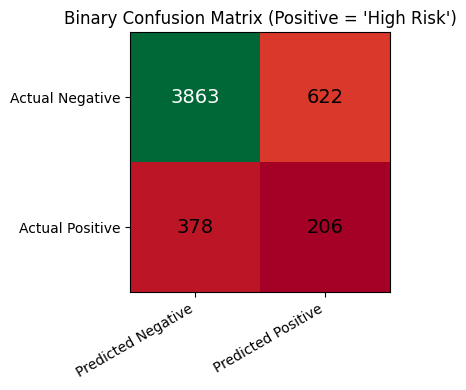

In [59]:
# Binary (2x2) confusion matrix for a chosen positive class (default: "High Risk")
positive_class = "High Risk"

# Binarize true and predicted labels: 1 = positive_class, 0 = not positive_class
y_test_bin = (y_test == positive_class).astype(int)
y_pred_bin = (pd.Series(y_pred) == positive_class).astype(int)

# Compute 2x2 confusion matrix: [[tn, fp], [fn, tp]]
cm2 = confusion_matrix(y_test_bin, y_pred_bin)
tn, fp, fn, tp = cm2.ravel()

# Create a labelled DataFrame (rows = Actual, cols = Predicted)
cm2_df = pd.DataFrame(
    [[int(tn), int(fp)], [int(fn), int(tp)]],
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)

# Save and display
cm2_df.to_csv(TAB_DIR / "table_19_confusion_matrix_binary_highrisk.csv", index=True)
print(cm2_df)

# Plot heatmap-like 2x2 matrix
fig, ax = plt.subplots(figsize=(5, 4))
cmap = plt.get_cmap("RdYlGn")
im = ax.imshow(cm2, interpolation="nearest", cmap=cmap)
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm2[i, j]), ha="center", va="center",
                color="white" if cm2[i, j] > cm2.max() / 2 else "black", fontsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(cm2_df.columns, rotation=30, ha="right")
ax.set_yticklabels(cm2_df.index)
ax.set_title(f"Binary Confusion Matrix (Positive = '{positive_class}')")
plt.tight_layout()
plt.show()

                 Predicted Negative  Predicted Positive
Actual Negative                3225                 435
Actual Positive                 664                 745


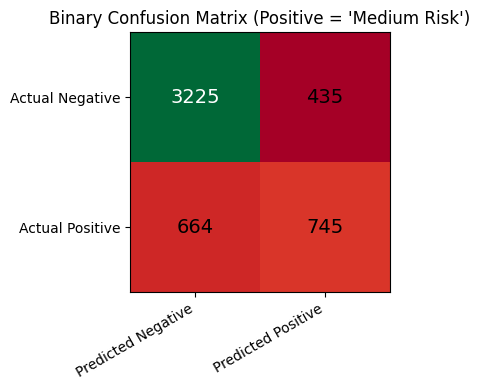

In [60]:
# Binary (2x2) confusion matrix for a chosen positive class (default: "High Risk")
positive_class = "Medium Risk"

# Binarize true and predicted labels: 1 = positive_class, 0 = not positive_class
y_test_bin = (y_test == positive_class).astype(int)
y_pred_bin = (pd.Series(y_pred) == positive_class).astype(int)

# Compute 2x2 confusion matrix: [[tn, fp], [fn, tp]]
cm2 = confusion_matrix(y_test_bin, y_pred_bin)
tn, fp, fn, tp = cm2.ravel()

# Create a labelled DataFrame (rows = Actual, cols = Predicted)
cm2_df = pd.DataFrame(
    [[int(tn), int(fp)], [int(fn), int(tp)]],
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)

# Save and display
cm2_df.to_csv(TAB_DIR / "table_20_confusion_matrix_binary_mediumrisk.csv", index=True)
print(cm2_df)

# Plot heatmap-like 2x2 matrix
fig, ax = plt.subplots(figsize=(5, 4))
cmap = plt.get_cmap("RdYlGn")
im = ax.imshow(cm2, interpolation="nearest", cmap=cmap)
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm2[i, j]), ha="center", va="center",
                color="white" if cm2[i, j] > cm2.max() / 2 else "black", fontsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(cm2_df.columns, rotation=30, ha="right")
ax.set_yticklabels(cm2_df.index)
ax.set_title(f"Binary Confusion Matrix (Positive = '{positive_class}')")
plt.tight_layout()
plt.show()

                 Predicted Negative  Predicted Positive
Actual Negative                1473                 520
Actual Positive                 535                2541


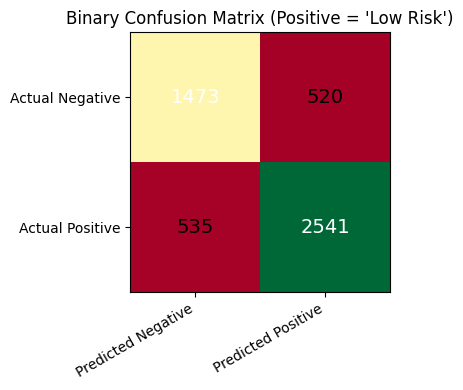

In [61]:
# Binary (2x2) confusion matrix for a chosen positive class (default: "High Risk")
positive_class = "Low Risk"

# Binarize true and predicted labels: 1 = positive_class, 0 = not positive_class
y_test_bin = (y_test == positive_class).astype(int)
y_pred_bin = (pd.Series(y_pred) == positive_class).astype(int)

# Compute 2x2 confusion matrix: [[tn, fp], [fn, tp]]
cm2 = confusion_matrix(y_test_bin, y_pred_bin)
tn, fp, fn, tp = cm2.ravel()

# Create a labelled DataFrame (rows = Actual, cols = Predicted)
cm2_df = pd.DataFrame(
    [[int(tn), int(fp)], [int(fn), int(tp)]],
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)

# Save and display
cm2_df.to_csv(TAB_DIR / "table_21_confusion_matrix_binary_lowrisk.csv", index=True)
print(cm2_df)

# Plot heatmap-like 2x2 matrix
fig, ax = plt.subplots(figsize=(5, 4))
cmap = plt.get_cmap("RdYlGn")
im = ax.imshow(cm2, interpolation="nearest", cmap=cmap)
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm2[i, j]), ha="center", va="center",
                color="white" if cm2[i, j] > cm2.max() / 2 else "black", fontsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(cm2_df.columns, rotation=30, ha="right")
ax.set_yticklabels(cm2_df.index)
ax.set_title(f"Binary Confusion Matrix (Positive = '{positive_class}')")
plt.tight_layout()
plt.show()

### 11. High Risk Focus

#### 11.1. ROC

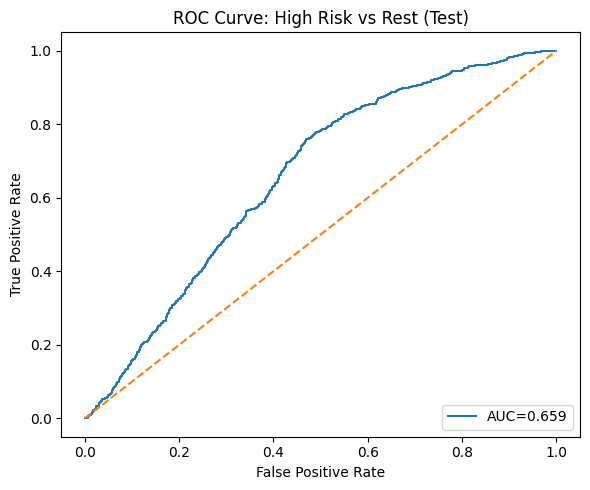

0.6585028481544265

In [62]:
# Get predicted probabilities for each class
proba = best_pipe.predict_proba(X_test)

# Binarize y_test for one-vs-rest curves
Y = label_binarize(y_test, classes=class_order)
high_idx = class_order.index("High Risk")

y_true_high = Y[:, high_idx]
y_score_high = proba[:, high_idx]

# ROC
fpr, tpr, _ = roc_curve(y_true_high, y_score_high)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_title("ROC Curve: High Risk vs Rest (Test)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_16_roc_high_risk_vs_rest.png", dpi=200)
plt.show()

roc_auc


**Interpretation:**<br>
The orange diagonal is what random guessing would look like. The blue curve sits above the diagonal, so the model does have signal for separating High Risk from not-High Risk.

#### 11.2. PR

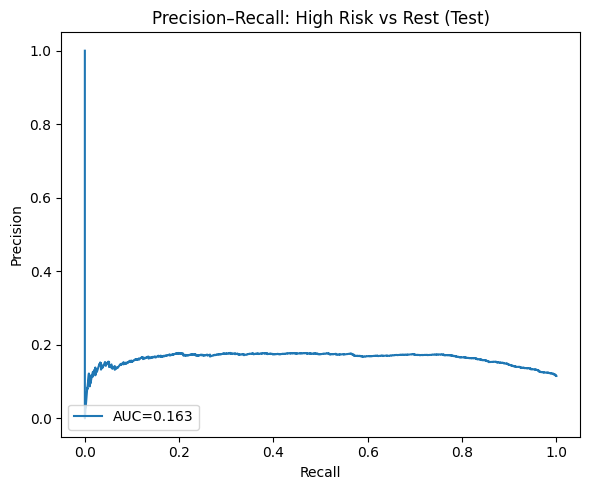

0.1630769922042678

In [63]:
# Precision-Recall
prec, rec, _ = precision_recall_curve(y_true_high, y_score_high)
pr_auc = auc(rec, prec)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(rec, prec, label=f"AUC={pr_auc:.3f}")
ax.set_title("Precision–Recall: High Risk vs Rest (Test)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="lower left")
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_17_pr_high_risk_vs_rest.png", dpi=200)
plt.show()

pr_auc


**Interpretation:**<br>
This shows that even with adjusting the threshold to catch more "High Risk" records, the proportion of flagged students doesn't improve much beyond random selection (about 0.11).

### 12. Misclassification

Most common misclassifications (not to rely on confusion matrix alone):



In [64]:
# Analyze misclassification pairs
err_df = pd.DataFrame({"true": y_test.values, "pred": y_pred})
err_df = err_df[err_df["true"] != err_df["pred"]].copy()

# Summarize misclassification pairs
err_summary = (
    err_df.groupby(["true", "pred"])                # Group by true/pred pairs
          .size()                                   # Count occurrences
          .rename("Count")                          # Name the count column
          .reset_index()                            # Reset index to turn groupby object into DataFrame    
          .sort_values("Count", ascending=False)    # Sort by count descending
)

# Save and display
print("Total misclassifications:", len(err_df))
# Save to CSV
err_summary.to_csv(TAB_DIR / "table_22_misclassification_pairs_test.csv", index=False)
err_summary.head(20)


Total misclassifications: 1577


,true,pred,Count
5,Medium Risk,Low Risk,339
4,Medium Risk,High Risk,325
2,Low Risk,High Risk,297
3,Low Risk,Medium Risk,238
1,High Risk,Medium Risk,197
0,High Risk,Low Risk,181


## Feature Importance / Coefficients

### 13. Listing Features

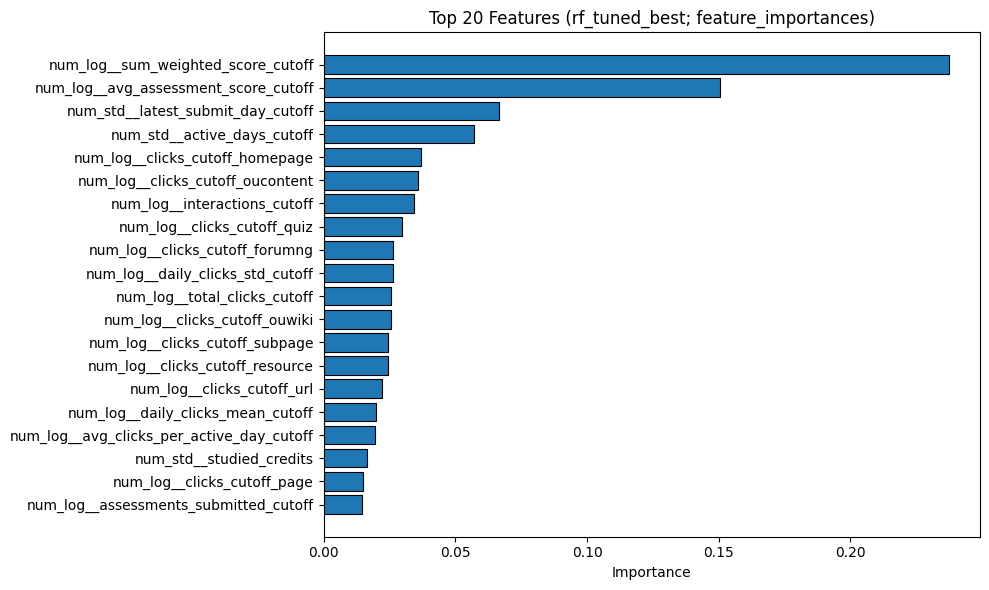

,feature,importance
2,num_log__sum_weighted_score_cutoff,0.237297
1,num_log__avg_assessment_score_cutoff,0.150596
29,num_std__latest_submit_day_cutoff,0.066686
30,num_std__active_days_cutoff,0.056941
13,num_log__clicks_cutoff_homepage,0.036885
16,num_log__clicks_cutoff_oucontent,0.035939
4,num_log__interactions_cutoff,0.034189
21,num_log__clicks_cutoff_quiz,0.029615
11,num_log__clicks_cutoff_forumng,0.026472
6,num_log__daily_clicks_std_cutoff,0.026328


In [65]:
# Feaures Used
pre = best_pipe.named_steps["preprocess"]
feat_names = pre.get_feature_names_out()

# Feature importance extraction
model = best_pipe.named_steps["model"]

# Determine importance based on model type
if hasattr(model, "coef_"):
    # multinomial: (n_classes, n_features) -> aggregate
    importance = np.mean(np.abs(model.coef_), axis=0)
    importance_kind = "mean_abs_coef"
elif hasattr(model, "feature_importances_"):
    importance = model.feature_importances_
    importance_kind = "feature_importances"
else:
    raise ValueError("Model does not expose coefficients or feature_importances_")

# Create DataFrame of feature importances
imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importance
}).sort_values("importance", ascending=False)

imp_df.to_csv(TAB_DIR / "table_23_feature_importance_best_model.csv", index=False)

# Plot top features
top_n = 20
top_imp = imp_df.head(top_n)

# Horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
# draw bars with a black edge for clearer borders
ax.barh(top_imp["feature"][::-1], top_imp["importance"][::-1], edgecolor="black", linewidth=0.8)
ax.set_title(f"Top {top_n} Features ({best_name}; {importance_kind})")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_18_top_features_best_model.png", dpi=200)
plt.show()

top_imp
